# Perfomance Test

Here we compare two implementations of the Hankel Function:
- Hankel: https://hankel.readthedocs.io/en/latest/index.html 
- Hankl: https://hankl.readthedocs.io/en/latest/

The second one was created specifically for power spectrum functions

In [1]:
import hankel
from hankel import HankelTransform     # Import the basic class
print("Using hankel v{}".format(hankel.__version__))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Using hankel v1.2.1


In [2]:
import hankl
print("Using hankel v{}".format(hankel.__version__))

Using hankel v1.2.1


## Matter Power Spectrum: CAMB

We use CAMB to have a power spectrum as an example.

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from time import time

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /usr/local/anaconda/lib/python3.8/site-packages/camb


### Get Matter power spectra for a given cosmology
Taken from notebook example: https://camb.readthedocs.io/en/latest/CAMBdemo.html

In [140]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 500)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 500)

Note: redshifts have been re-sorted (earliest first)


In [141]:
print(results.get_sigma8())


[0.53298468 0.80251083]


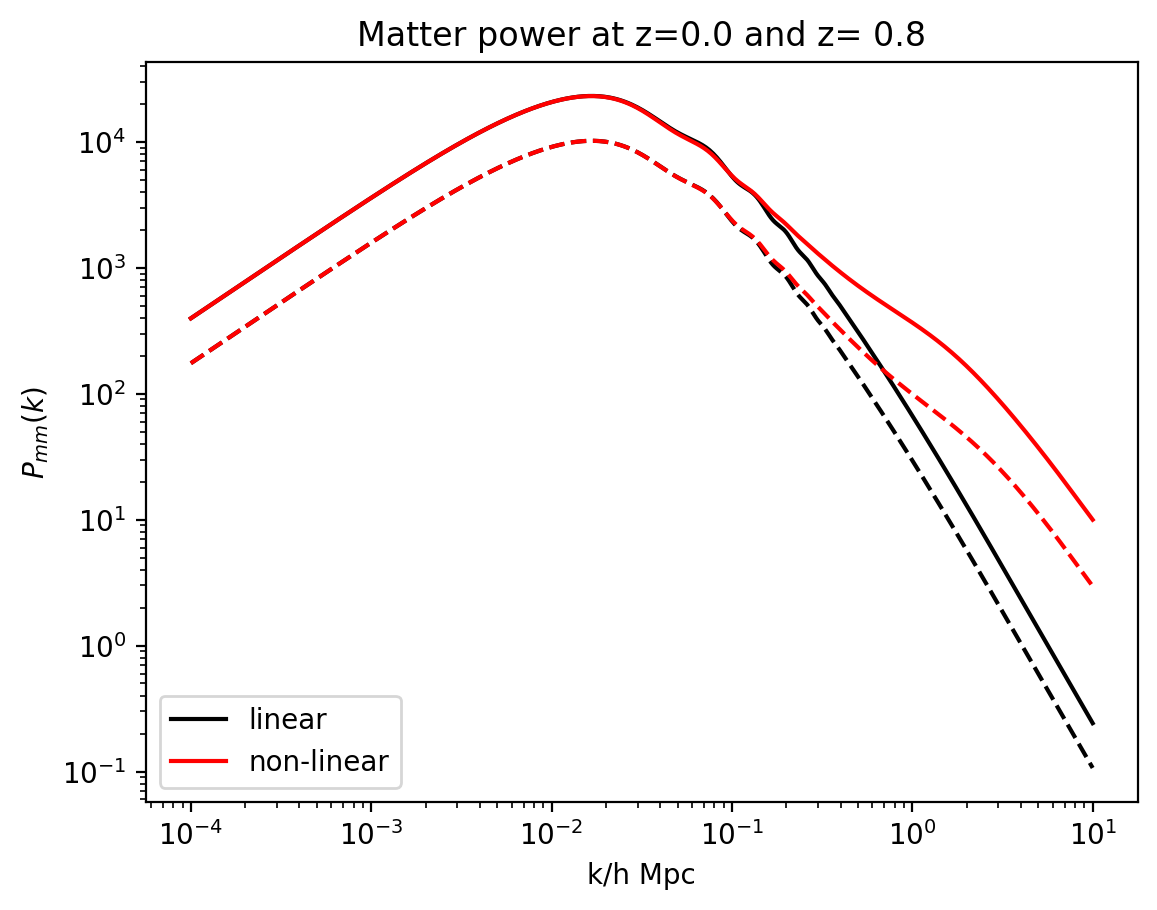

In [145]:
for i, (redshift, line) in enumerate(zip(z_lin,['-','--'])):
    plt.loglog(kh_lin, pk_lin[i,:], color='k', ls = line)
    plt.loglog(kh_nonlin, pk_nonlin[i,:], color='r', ls = line)
plt.xlabel('k/h Mpc');
plt.ylabel(r'$P_{mm}(k)$')
plt.legend(['linear','non-linear'], loc='lower left');
plt.title('Matter power at z=%s and z= %s'%tuple(z));

# Hankel Transformations

The hankel transformations are important for several reasons. 
- First, the first order hankel transformation of the $P_{mm}(k)$ is $\xi_{mm} (R)$ matter correlation functions in real space. After some test perfomed by Chiara, she showed that is  the most accurate computation of $\xi_{mm}$. 
- Second, applying a second order hankel transformation we can estimate $\gamma_t (\theta)$ directly. See Equation 12, https://arxiv.org/pdf/0910.1361.pdf

In [146]:
eTimes = dict()

In [154]:
# at redshift 0
pk = pk_nonlin[0]
k = kh_nonlin

Now, this was the linear Matter Power Spectrum, to get the Galaxy Power Spectrum multipoles we will use Kaiser’s formula:
$$
P(k, \mu) = (b+f\mu^2) ^ 2 P_lin(k)
$$

In [155]:
def get_multipoles(pk, b, f):

    p0 = (b*b + 2.0 * b *f / 3.0 + f*f/5.0 ) * pk

    p2 = (4.0*b*f/3.0 + 4.0*f*f/7.0) * pk

    p4 = (8.0* f*f / 35.0) * pk

    return p0, p2, p4

In [156]:
P0, P2, P4 = get_multipoles(pk, b=2.0, f=0.5)


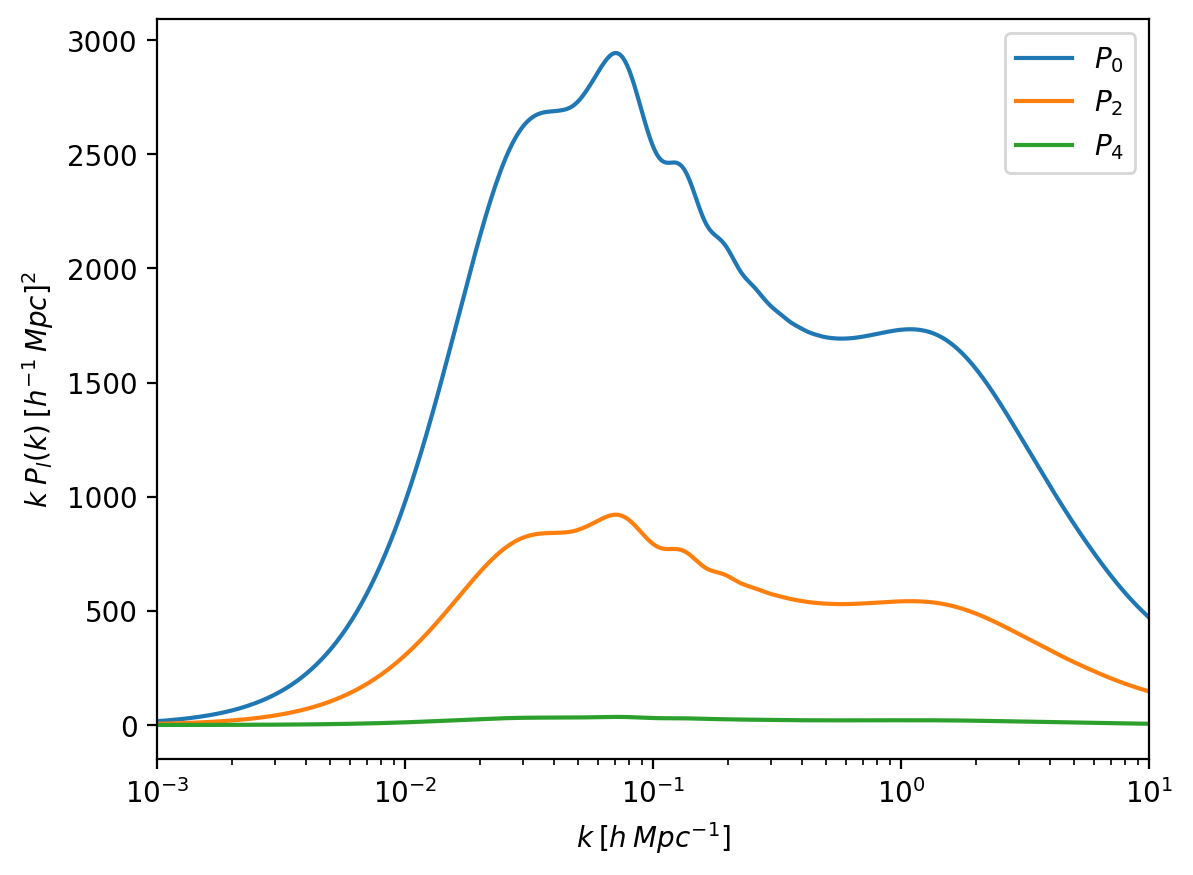

In [157]:
plt.semilogx(k, k * P0, label=r'$P_{0}$')
plt.semilogx(k, k * P2, label=r'$P_{2}$')
plt.semilogx(k, k * P4, label=r'$P_{4}$')
plt.xlabel(r'$k \: [h\: Mpc^{-1}]$')
plt.ylabel(r'$k\; P_{l}(k) \: [h^{-1}\: Mpc]^{2}$')
plt.xlim(1e-3, 10)
plt.legend()
plt.show()

In [158]:
# Using Hankl - a code created to cosmology computations
#  https://hankl.readthedocs.io/en/latest/examples.html

t0 = time()
s, xi0 = hankl.P2xi(k, P0, l=0)

eTimes['Hankl'] = [(time()-t0)*1000]
print('It takes %.3f msec'%(eTimes['Hankl'][0]))

It takes 1.011 msec


In [159]:
# Using Hankl - a code created to cosmology computations
#  https://hankl.readthedocs.io/en/latest/examples.html

t0 = time()
s, xi2 = hankl.P2xi(k, P0, l=2)

eTimes['Hankl'] += [(time()-t0)*1000]
print('It takes %.3f msec'%(eTimes['Hankl'][0]))

It takes 1.011 msec


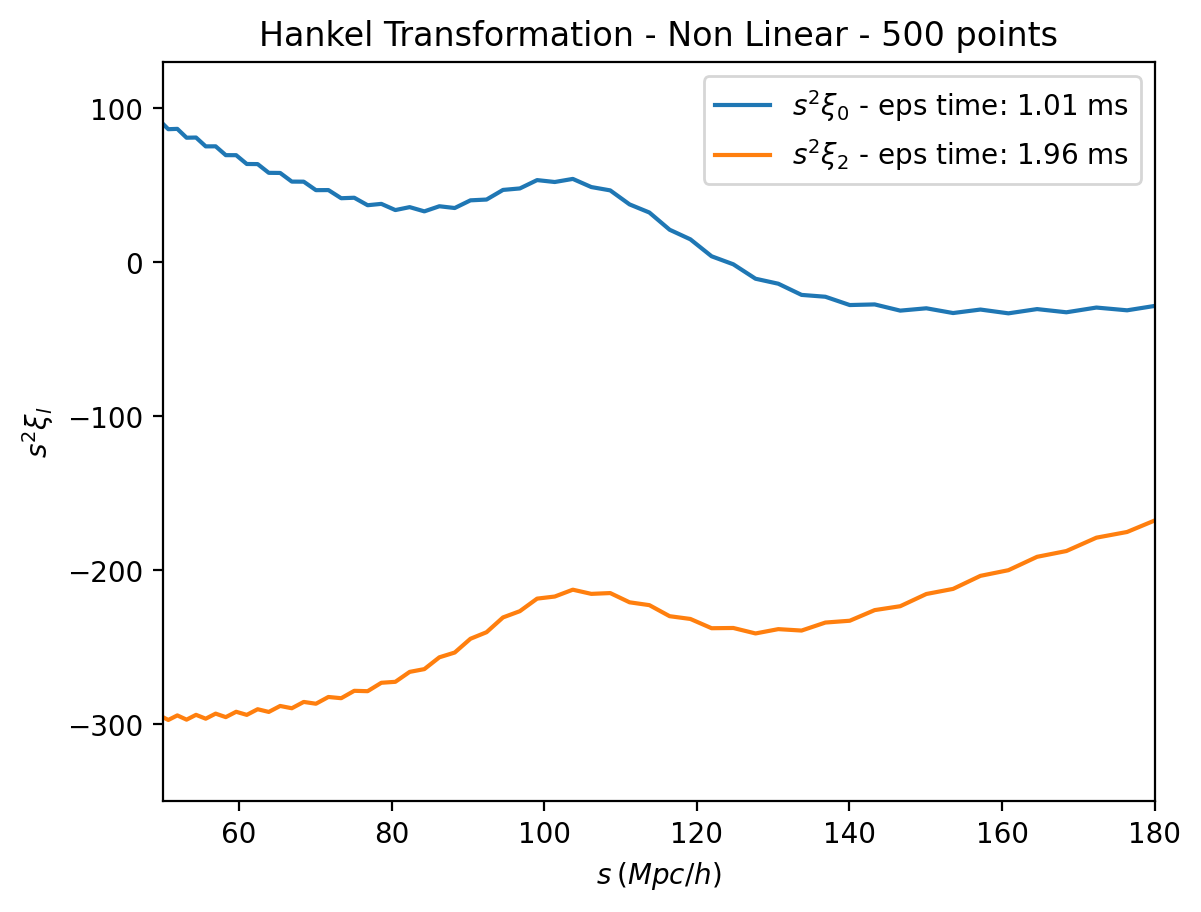

In [161]:
# plt.loglog()
plt.plot(s, s*s*xi0, label=r'$s^{2}\xi_{0}$ - eps time: %.2f ms'%eTimes['Hankl'][0])
plt.plot(s, s*s*xi2, label=r'$s^{2}\xi_{2}$ - eps time: %.2f ms'%eTimes['Hankl'][1])
plt.xlim(50,180)
plt.ylim(-350,130)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$s^{2} \xi_{l}$')
plt.legend()
plt.title('Hankel Transformation - Non Linear - 500 points')
plt.show()